In [1]:
%matplotlib inline
import RR_RAPPOR
import timeit
import scipy.io as io
import datetime
from scipy import optimize

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import scipy.io as io
import functions as f
import os
import pickle
from onebit_hadamard import Hadamard_Rand_high_priv, Hadamard_Rand_general

In [12]:
def generate_samples(n, m, prob):
    k = len(prob)
    return np.random.choice(range(0, k), (n, m), p=prob)


class LocalizationUtil:
    def __init__(self, m, C):
        self.m = m
        self.C = C
        self.r = int(np.sqrt(self.m/(2*self.C)))
        if 1/2-self.id_to_p(self.r)<= self.C*(2*self.r-1)/(self.m * 3):
            # if the last interval is too small, don't add a breakpoint.
            self.r = self.r - 1
        self.points = np.zeros(2*self.r+3)
        for i in range(self.r + 1):
            self.points[i] = self.id_to_p(i)
        self.points[self.r+1] = 1/2
        for i in range(self.r, -1, -1):
            self.points[2*self.r-i+2] = (1 - self.id_to_p(i))

        self.shifted_points = np.zeros(2*self.r+4)
        for i in range(len(self.points)-1):
            self.shifted_points[i+1] = (self.points[i]+self.points[i+1])/2
        self.shifted_points[-1] = 1

    def compute_binom(self, p):
        m = self.m
        binom = np.zeros(m+1)
        q = 1-p
        p_pow = np.ones(m+1)
        q_pow = np.ones(m+1)
        
        for k in range(1, m+1):
            p_pow[k] = p_pow[k-1]*p
            q_pow[k] = q_pow[k-1]*q
        
        if q == 0:
            binom[m] = 1
            return binom
        binom[0] = q_pow[m]
        for k in range(1, m+1):
            binom[k] = binom[k-1] * (m-k+1) * p / (k * q)
        return binom
    
    def get_interval_size(self):
        """Determine the number of intervals to divide [0, 1/2]"""
        return 2 * self.r + 2

    def _get_interval_id_small_count(self, counts):
        return np.minimum(np.sqrt(counts/self.C).astype(int), self.r)
    
    def get_interval_id(self, counts):
        indic = counts <= self.m/2
        return indic * self._get_interval_id_small_count(counts) + (1-indic)*(2*self.r+1 - self._get_interval_id_small_count(self.m - counts))
    
    def get_shifted_interval_id(self, counts):
        idx = self.get_interval_id(counts)
        th = self.C * (idx **2 + (idx+1)**2)/ (2*self.m)
        freq = counts/self.m
        indic = freq < th
        return indic * idx + (1-indic)*(idx+1)
    
    def id_to_count(self, i):
        return min(self.C * i**2, self.m/2)
    
    def id_to_p(self, i):
        return self.id_to_count(i)/self.m
    
    def get_p_range(self, p_id):
        assert p_id<=2*self.r + 2 and p_id>=0
        if p_id <= self.r:
            return np.array([self.id_to_p(p_id), self.id_to_p(p_id+1)])
        else:
            sym_p_id = 2*self.r+1-p_id
            return 1 - np.array([self.id_to_p(sym_p_id+1), self.id_to_p(sym_p_id)])
    
    def diff(self, p, freq, id_func):
        count_id = np.array([id_func(k) for k in range(self.m+1)])
        id_parity = count_id % 2
        binom = self.compute_binom(p)
        val = np.sum(binom * id_parity)
        return (val - freq)**2
    
    def _get_estimate(self, p_int, freq, shifted):
        assert freq<=1 and freq>=0
        p0 = np.average(p_int)
        if shifted:
            id_func = self.get_shifted_interval_id
        else:
            id_func = self.get_interval_id
        res = optimize.minimize(self.diff, p0, args=(freq, id_func), method='Nelder-Mead', tol=1e-7)
        return max(min(p_int[1], res.x[0]), p_int[0])
    
    def _test_large_deriv(self, p_int, pt_array):
        test_pt_in_interval = (pt_array>= p_int[0]- 1e-5)*(pt_array <= p_int[1]+1e-5)
        return np.sum(test_pt_in_interval)>=1
    
    def get_estimate(self, p_int, freq, freq_shifted):
        if self._test_large_deriv(p_int, self.points):
#             print('Using non-shifted')
            return self._get_estimate(p_int, freq, shifted=False)
        elif self._test_large_deriv(p_int, self.shifted_points):
#             print('Using shifted')
            return self._get_estimate(p_int, freq_shifted, shifted=True)
        else:
            print('No')
            return np.average(p_int) # Should not happen, but return a coarse estimate just in case.

In [22]:
def get_odd_freq_priv(refine_users, eps):
    n = len(refine_users)
    refine_msg_binary = refine_users % 2
    flip_indic = np.random.binomial(1, 1/(np.exp(eps)+1), n)
    refine_msg_priv = (flip_indic + refine_msg_binary) % 2
    odd_freq_priv = np.average(refine_msg_priv)
    return odd_freq_priv

def RR(msg_binary, eps):
    n = len(msg_binary)
    flip_indic = np.random.binomial(1, 1/(np.exp(eps)+1), n)
    refine_msg_priv = (flip_indic + msg_binary) % 2
    freq_priv = np.average(refine_msg_priv)
    return freq_priv

def estimate_from_priv(p_priv, eps):
    beta = 1/(np.exp(eps)+1)
    return max(min((p_priv - beta)/(1-2*beta), 1), 0)

In [92]:
class Estimator:
    def __init__(self, m, n, C_I, eps, user_data=None, interactive=False):
        self.m = m
        self.n = n
        self.n_g = int(n/3)
        self.C_I = C_I
        self.eps = eps
        self.user_data = user_data
        self.interactive = interactive
        self.R_ratio = 3.5
        if user_data is not None:
            self.user_counts = np.sum(user_data, axis=1)

    def compute_binom(self, p):
        m = self.m
        binom = np.zeros(m+1)
        q = 1-p
        p_pow = np.ones(m+1)
        q_pow = np.ones(m+1)
        
        for k in range(1, m+1):
            p_pow[k] = p_pow[k-1]*p
            q_pow[k] = q_pow[k-1]*q
        
        if q == 0:
            binom[m] = 1
            return binom
        binom[0] = q_pow[m]
        for k in range(1, m+1):
            binom[k] = binom[k-1] * (m-k+1) * p / (k * q)
        return binom
    
    def diff(self, p, freq, th):
        th_indic = np.arange(self.m + 1) >= self.m*th
        binom = self.compute_binom(p)
        val = np.sum(binom * th_indic)
        return (val - freq)**2
    
    def localization(self):
        # localization
        Loc = LocalizationUtil(self.m, self.C_I)
        num_bins = Loc.get_interval_size()
        n = self.n_g
        loc_counts = self.user_counts[:n]
        loc_bin_id = Loc.get_interval_id(loc_counts)
        rappor = RR_RAPPOR.RAPPOR(num_bins, self.eps)
        sample = rappor.encode_string(loc_bin_id) 
        outp = np.sum(sample, axis=0)
        prob_est = rappor.decode_counts(outp, n)
        p_id = np.argmax(prob_est)
        p_int = Loc.get_p_range(p_id)
        return p_int

    # refinement
    def refine(self, p_int):
        C_R = self.R_ratio * self.C_I
        m = self.m
        n = self.n_g
        eps = self.eps
        Refine = LocalizationUtil(m, C_R)

        refine_user_counts = self.user_counts[n:]
        refine_user_bin_id = Refine.get_interval_id(refine_user_counts)
        refine_user_shifted_id = Refine.get_shifted_interval_id(refine_user_counts)

        freq1 = estimate_from_priv(get_odd_freq_priv(refine_user_bin_id[:n], eps), eps)
        freq2 = estimate_from_priv(get_odd_freq_priv(refine_user_shifted_id[:-n], eps), eps)

        est1 = Refine.get_estimate(p_int, freq1, freq2)
        return est1

    def refine_interactive(self, p_int):
        th = np.average(p_int)
        refine_user_counts = self.user_counts[self.n_g:]
        indic = refine_user_counts >= self.m*th
        priv_indic = RR(indic, self.eps)
        freq = estimate_from_priv(priv_indic, self.eps)
        res = optimize.minimize(self.diff, th, args=(freq, th), method='Nelder-Mead', tol=1e-7)
        return max(min(p_int[1], res.x[0]), p_int[0])
        
    def expand_int(self, p_int, ratio=1.2):
        mid = np.average(p_int)
        radius = (p_int[1]-p_int[0])/2
        return np.array([max(mid - radius * ratio, 0), min(mid + radius * ratio, 1)])
    
    def estimate(self, user_data =  None):
        if user_data is not None:
            self.user_data = user_data
            self.user_counts = np.sum(user_data, axis=1)
            self.n = len(user_data)
            self.n_g = int(self.n/3)

        if self.user_data is not None:
            self.n = len(self.user_data)
            self.n_g = int(self.n/3)
            p_int = self.localization()
            if self.interactive:
                p_est = self.refine_interactive(p_int)
            else:
                p_est = self.refine(self.expand_int(p_int))
            return p_est
        else:
            raise ValueError('Please input user data!')

In [93]:
class Experiment:
    def __init__(self, eps, n, m, p, C_I=1, rep=10, interactive=False, verbose=False):
        self.eps = eps
        self.n = n
        self.m = m
        self.p = p
        self.rep = rep
        self.interactive = interactive
        self.verbose = verbose
        self.C_I = C_I
        
        self.labels = ['multi', 'single', 'all']
        self.est_raw = {'multi': [], 'single': [], 'all': []}
    
    def run_multi_sample(self, user_data):
        estimator = Estimator(self.m, self.n, self.C_I, self.eps, user_data, self.interactive)
        p_est = estimator.estimate()
        return p_est
    
    def run_single_sample(self, user_data):
        P = RR(user_data[:, 0])
        p_rr = estimate_from_priv(P, self.eps)
        return p_rr
     
    def run_all_sample(self, user_data):
        P = RR(user_data.flatten())
        p_all = estimate_from_priv(P, self.eps)
        return p_all
        
    def run_experiment(self):
        rep = self.rep
        p = self.p
        prob = np.array([1-p, p])
        error_multi = np.zeros(rep)
        error_single = np.zeros(rep)
        error_all = np.zeros(rep)

        for r in range(rep):
            user_data = generate_samples(self.n, self.m, prob)
            estimator = Estimator(self.m, self.n, self.C_I, self.eps, user_data, self.interactive)
            p_est = estimator.estimate()
            error_multi[r] = abs(p_est - self.p)
            self.est_raw['multi'].append(p_est)

            # Single sample RR
            P = RR(user_data[:, 0], self.eps)
            p_rr = estimate_from_priv(P, self.eps)
            error_single[r] = abs(p_rr-self.p)
            self.est_raw['single'].append(p_rr)

            # RR with 3m*n samples
            P = RR(user_data.flatten(), self.eps)
            p_all = estimate_from_priv(P, self.eps)
            error_all[r] = abs(p_all-self.p)
            self.est_raw['all'].append(p_all)
            
            if self.verbose:
                print(f'Iter {r}')
                print(f'p_est={p_est}  error={abs(p_est - p)}')
                print(abs(p_rr-self.p))
                print(abs(p_all-self.p))       
        
        return {'multi': np.average(error_multi), 'single': np.average(error_single), 'all':np.average(error_all)}
    
    def compute_error(self):
        avg_l1_errors = {}
        err_std = {}
        for label in self.labels:
            label_errors = np.abs(np.array(self.est_raw[label]) - self.p)
            avg_l1_errors[label] = np.average(label_errors)
            err_std[label] = np.std(label_errors)
        return avg_l1_errors, err_std

In [94]:
class HighDimExperiment:
    def __init__(self, k, eps, n, m, p, C_I=1, rep=10, interactive=False, verbose=False):
        self.k = k
        self.eps = eps
        self.n = n
        self.m = m
        self.p = p
        self.rep = rep
        self.interactive = interactive
        self.verbose = verbose
        self.C_I = C_I
        
        self.labels = ['multi', 'single', 'all']
        self.est_raw = {'multi': [], 'single': [], 'all': []}
    
    def run_simple_multi(self, user_data):
        kEstimator = SimpleLowPrivEstimator(self.k, self.m, self.n, self.C_I, self.eps, self.interactive)
        p_est = kEstimator.estimate(user_data)
        return p_est
    
    def run_mid_range(self, user_data):
        estimator = MidRangeEstimator(self.k, self.m, self.n, self.C_I, self.eps, self.interactive)
        p_est = estimator.estimate(user_data)
        return p_est
    
    def run_multi_sample(self, user_data):
        if self.m >= self.k or self.eps<=1:
            return self.run_simple_multi(user_data)
        else:
            return self.run_mid_range(user_data)
    
    def run_single_hr(self, user_data):
        if self.eps<=1:
            hadamard_estimator = Hadamard_Rand_high_priv(self.k, self.eps, 1)
        else:
            hadamard_estimator = Hadamard_Rand_general(self.k, self.eps, 1)
        outp = hadamard_estimator.encode_string(user_data[:, 0])
        tp_b = hadamard_estimator.decode_string(outp, normalization=1)
        return tp_b
    
    def run_all_hr(self, user_data):
        if self.eps<=1:
            hadamard_estimator = Hadamard_Rand_high_priv(self.k, self.eps, 1)
        else:
            hadamard_estimator = Hadamard_Rand_general(self.k, self.eps, 1)
        outp = hadamard_estimator.encode_string(user_data.flatten())
        tp_b = hadamard_estimator.decode_string(outp, normalization=1)
        return tp_b
    
    def run_experiment(self):
        rep = self.rep
        prob = self.p
        error_multi = np.zeros(rep)
        error_single = np.zeros(rep)
        error_all = np.zeros(rep)

        for r in range(rep):
            user_data = generate_samples(self.n, self.m, prob)
            p_est = self.run_multi_sample(user_data)
            error_multi[r] = np.sum(abs(p_est - self.p))/2
            self.est_raw['multi'].append(p_est)

            # Single sample HR
            p_rr = self.run_single_hr(user_data)
            error_single[r] = np.sum(abs(p_rr-self.p))/2
            self.est_raw['single'].append(p_rr)

            # RR with m*n samples
            p_all = self.run_all_hr(user_data)
            error_all[r] = np.sum(abs(p_all-self.p))/2
            self.est_raw['all'].append(p_all)
            
            if self.verbose:
                print(f'Iter {r}')
                print(error_multi[r], error_single[r], error_all[r])      
        
        return {'multi': np.average(error_multi), 'single': np.average(error_single), 'all':np.average(error_all)}
    
    def compute_error(self):
        avg_TV_errors = {}
        err_std = {}
        for label in self.labels:
            label_errors = np.sum(np.abs(np.array(self.est_raw[label]) - self.p), axis=1)/2
            avg_TV_errors[label] = np.average(label_errors)
            err_std[label] = np.std(label_errors)
        return avg_TV_errors, err_std

In [95]:
class HighPrivEstimator:
    def __init__(self, k, m, n, C_I, eps, user_data, interactive=False):
        self.k = k
        self.m = m
        self.n = n
        self.C_I = C_I
        self.eps = eps
        self.flip_prob = 1/(1+math.exp(eps)) 
        self.user_data = user_data
        self.outsz = int(math.pow(2,math.ceil(math.log(k+1,2))))
        self.H = np.array(f.Hadamard_init(self.outsz))
        self.interactive = interactive
        self.binom_estimator = Estimator(self.m, self.n, self.C_I, self.eps, interactive=self.interactive)
    
    def estimate(self, user_data):
        self.user_data = user_data
        self.n = len(self.user_data)
        row_assignment = np.arange(self.n) % self.outsz
        p_C = np.zeros(self.outsz)
        
        for r in range(self.outsz):
            users_r = self.user_data[row_assignment == r]
            row_r_data = self.H[r][users_r].astype(int)
            p_C[r] = self.binom_estimator.estimate(row_r_data)
            
        p_K = f.FWHT_A(self.outsz, 2*p_C - np.ones(self.outsz))/self.outsz
        p_k = p_K[0:self.k]
        p_k = f.project_probability_simplex(p_k)
        return p_k

In [96]:
class SimpleLowPrivEstimator:
    def __init__(self, k, m, n, C_I, eps, interactive=False):
        self.k = k
        self.m = m
        self.n = n
        self.C_I = C_I
        self.eps = eps
        self.outsz = int(math.pow(2,math.ceil(math.log(k+1,2))))
        self.interactive = interactive

    
    def estimate(self, user_data):
        if self.eps<=1:
            aux_estimator = HighPrivEstimator(self.k, self.m, self.n, self.C_I, self.eps, user_data, self.interactive)
            return aux_estimator.estimate(user_data)
        else:
            rows_per_user = min(int(self.eps), self.outsz)
            new_data = np.repeat(user_data, rows_per_user, axis=0)
            aux_estimator = HighPrivEstimator(self.k, self.m, self.n*rows_per_user, self.C_I, 1, new_data, self.interactive)
            return aux_estimator.estimate(new_data)

In [97]:
class MidRangeEstimator:
    def __init__(self, k, m, n, C_I, eps, interactive=False):
        self.k = k
        self.m = m
        self.n = n
        self.C_I = C_I
        self.eps = eps
        self.interactive = interactive
        self.outsz = int(math.pow(2,math.ceil(math.log(k+1,2))))
    
    def estimate(self, user_data):
        self.user_data = user_data
        self.n = len(self.user_data)
        b_size = math.ceil(self.k/self.m) # Size of each block. Append 0 to the domain if k is not a multiple of m
        
        eps0 = 1 if self.eps<= 2*np.log(self.k/self.m + 0.1) else self.eps/2
        block_data = self.user_data % self.m # divide user data according to mod m
        block_distr_estimator = SimpleLowPrivEstimator(self.m, self.m, self.n, self.C_I, eps0, self.interactive)
        p_B = block_distr_estimator.estimate(block_data)
        
        t = min(max(1, int(self.eps/(2*np.log(self.k/self.m + 0.1) ))), self.m)
        new_data =  np.repeat(self.user_data, t, axis=0)
        new_block_data =  np.repeat(block_data, t, axis=0)

        hadamard_estimator = Hadamard_Rand_general(b_size + 1, (self.eps - eps0)/t, 1)
        block_assignment = np.arange(self.n * t) % self.m
        p_out = np.zeros(self.m*b_size)
        for b in range(self.m):
            b_user_data = new_data[block_assignment==b]
            n_users_b = len(b_user_data)
            b_block_data = new_block_data[block_assignment==b]
            in_block = b_block_data==b # indicates whether each data is in block b
            
            # for each user, return the first element that appears in block b. If there is no such element, return b_size
            b_element_data = np.where(in_block.any(axis=1), 
                                      (b_user_data[range(n_users_b), in_block.argmax(axis=1)]/self.m).astype(int), 
                                      b_size)
            
            # Estimate distribution within block using HR
            outp = hadamard_estimator.encode_string(b_element_data)
            tp_b = hadamard_estimator.decode_string(outp, normalization=1)
            if tp_b[-1] == 1:
                p_b = np.ones(b_size)/b_size
            else:
                p_b = tp_b[0:b_size]/(1-tp_b[-1])
            p_out[b+np.arange(b_size)*self.m] = p_b * p_B[b]
        return p_out[0:self.k] 

In [149]:
class PlotExperiment:
    def __init__(self, prob, k, n, C_I=1, rep=5, save_filename='', interactive=True, verbose=True):
        self.prob = prob
        self.k = k
        self.n = n
        self.C_I = C_I
        self.rep = rep
        self.interactive = interactive
        self.verbose = verbose
        self.eps_list = []
        self.m_list = []
        self.errors = []
        self.stds = []
        self.save_filename = save_filename
    
    def run_experiment(self, eps_list, m_list):
        self.eps_list = eps_list
        self.m_list = m_list
        self.errors = []
        self.stds = []
        for eps in eps_list:
            eps_error = []
            eps_std = []
            for m in m_list:
                if self.verbose:
                    print('eps=', eps, 'm=', m, self.prob[0])
                if k > 2:
                    experiment = HighDimExperiment(self.k, eps, self.n, m, self.prob, C_I=self.C_I, rep=self.rep, interactive=self.interactive, verbose=self.verbose)
                else:
                    experiment = Experiment(eps, self.n, m, self.prob[0], C_I=self.C_I, rep=self.rep, interactive=self.interactive)
                result = experiment.run_experiment()
                error, std = experiment.compute_error()
                if self.verbose:
                    print('TV error=', error, 'std=', std)
                eps_error.append(error)
                eps_std.append(std)
                if self.save_filename != '':
                    self.save_result(self.save_filename)
            self.errors.append(eps_error)
            self.stds.append(eps_std)

    def save_result(self, filename):
        result = {'k': self.k, 
                  'n': self.n, 
                  'prob': self.prob, 
                  'interactive': self.interactive, 
                  'eps_list': eps_list, 
                  'm_list': m_list, 
                  'rep': self.rep,
                  'errors': self.errors,
                  'stds': self.stds}
        with open(filename, 'wb') as f:
            pickle.dump(result, f)
            
    def load_result(self, filename):
        with open(filename, 'rb') as f:
            result = pickle.load(f)
            self.k = result['k']
            self.n = result['n']
            self.prob = result['prob']
            self.interactive = result['interactive']
            self.eps_list = result['eps_list']
            self.rep = result['rep']
            self.m_list = result['m_list']
            self.errors = result['errors']
            self.stds = result['stds']
        return result
            
    def plot_m(self, eps):
        eps_id = self.eps_list.index(eps)
        errors = self.errors[eps_id]
        stds = self.stds[eps_id]
        
        n_exp = len(self.m_list)
        error_multi = np.array([errors[i]['multi'] for i in range(n_exp)])
        error_single = np.array([errors[i]['single'] for i in range(n_exp)])
        error_all = np.array([errors[i]['all'] for i in range(n_exp)])

        std_multi = [stds[i]['multi'] for i in range(n_exp)]
        std_single = [stds[i]['single'] for i in range(n_exp)]
        std_all = [stds[i]['all'] for i in range(n_exp)]

        plt.figure()
        plt.xlabel('m: number of samples per user')
        plt.ylabel('Expected TV error')
        plt.errorbar(self.m_list, error_multi, yerr=std_multi, label='multi')
        plt.errorbar(self.m_list, error_single, yerr=std_single, label='single')
        plt.errorbar(self.m_list, error_all, yerr=std_all, label='all')
        plt.legend()
        
        plt.figure()
        plt.xlabel('m: number of samples per user')
        plt.ylabel('Error ratio to all-sample HR')
        plt.plot(self.m_list, error_multi/error_all, label='multi/all')
        plt.plot(self.m_list, error_single/error_all, label='single/all')
        plt.legend()
        
    def plot_eps(self, m):
        m_id = self.m_list.index(m)
        n_exp = len(self.eps_list)
        errors = [self.errors[i][m_id] for i in range(n_exp)]
        stds = [self.stds[i][m_id] for i in range(n_exp)]
        
        error_multi = np.array([errors[i]['multi'] for i in range(n_exp)])
        error_single = np.array([errors[i]['single'] for i in range(n_exp)])
        error_all = np.array([errors[i]['all'] for i in range(n_exp)])

        std_multi = [stds[i]['multi'] for i in range(n_exp)]
        std_single = [stds[i]['single'] for i in range(n_exp)]
        std_all = [stds[i]['all'] for i in range(n_exp)]

        plt.figure()
        plt.xlabel('epsilon: privacy parameter')
        plt.ylabel('Expected TV error')
        plt.errorbar(self.eps_list, error_multi, yerr=std_multi, label='multi')
        plt.errorbar(self.eps_list, error_single, yerr=std_single, label='single')
        plt.errorbar(self.eps_list, error_all, yerr=std_all, label='all')
        plt.legend()
        
        plt.figure()
        plt.xlabel('epsilon: privacy parameter')       
        plt.ylabel('Error ratio to all-sample HR')
        plt.plot(self.eps_list, error_multi/error_all, label='multi/all')
        plt.plot(self.eps_list, error_single/error_all, label='single/all')
        plt.legend()

In [139]:
save_dir = './results/'
rep = 20
k = 2
n = 9000
C_I = 0.6
for p in [0.1, 0.2, 0.3, 0.4]:
    prob = [p, 1-p]
    interactive = True
    filename = f'k={k},n={n},C_I={C_I},p={p},interact={interactive}.pkl'
    eps_list = [0.9]
    m_list = 2**np.arange(5, 11)

    save_path = os.path.join(save_dir, filename)
    non_int_experiment = PlotExperiment(prob, k, n, C_I, rep, save_filename=save_path, interactive=interactive, verbose=True)
    non_int_experiment.run_experiment(eps_list, m_list)
    non_int_experiment.save_result(save_path)

eps= 0.9 m= 32 0.1
TV error= {'multi': 0.0012218486070632978, 'single': 0.01040270025355505, 'all': 0.0017066803322217869} std= {'multi': 0.0008193347969835277, 'single': 0.005374486412333974, 'all': 0.0010150797964995355}
eps= 0.9 m= 64 0.1
TV error= {'multi': 0.001025593578815462, 'single': 0.008453839952889052, 'all': 0.0010258168401859572} std= {'multi': 0.0006756500979406849, 'single': 0.005344260886961188, 'all': 0.0010376975969163351}
eps= 0.9 m= 128 0.1
TV error= {'multi': 0.0008773913979530354, 'single': 0.009050706891762808, 'all': 0.0007575827401047327} std= {'multi': 0.0005291003666828708, 'single': 0.007014350782749845, 'all': 0.0006502456160788205}
eps= 0.9 m= 256 0.1
TV error= {'multi': 0.0003990685939788831, 'single': 0.010960307051406043, 'all': 0.0007499573264281772} std= {'multi': 0.000381723199944745, 'single': 0.004805434792109354, 'all': 0.00040244778166610175}
eps= 0.9 m= 512 0.1
TV error= {'multi': 0.0004618410095572463, 'single': 0.007773169532335572, 'all': 0.

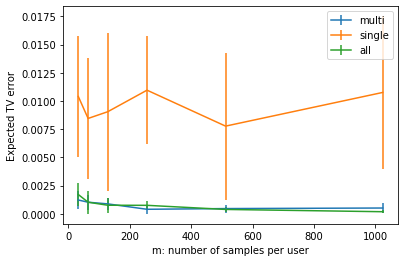

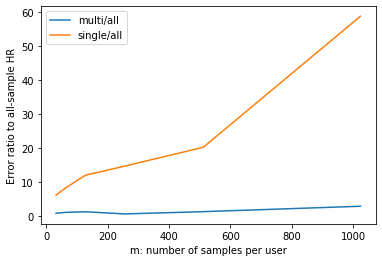

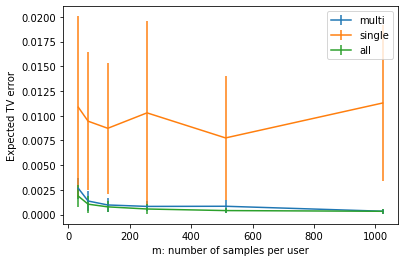

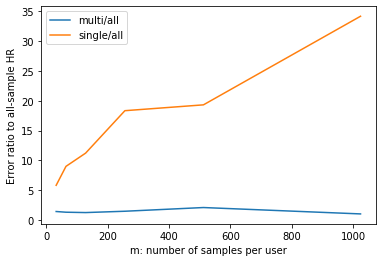

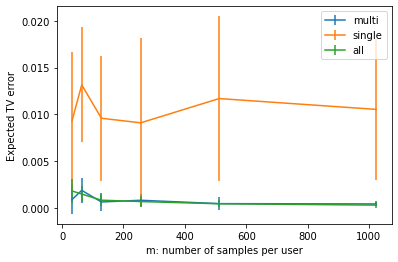

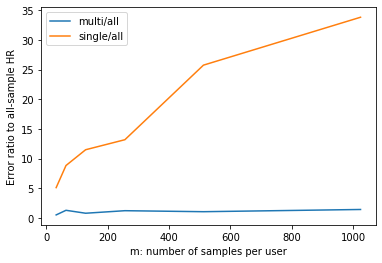

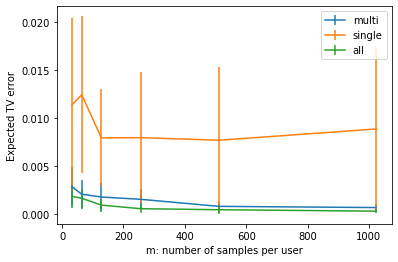

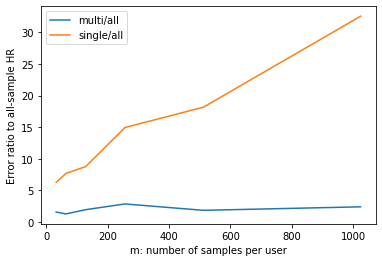

In [140]:
k = 2
n = 9000
C_I = 0.6
interactive = True
for p in [0.1, 0.2, 0.3, 0.4]:
    prob = [p, 1-p]

    filename = f'k={k},n={n},C_I={C_I},p={p},interact={interactive}.pkl'
    eps_list = [0.9]
    m_list = 2**np.arange(5, 11)

    save_path = os.path.join(save_dir, filename)
    non_int_experiment = PlotExperiment(prob=prob, k=k, n=n, save_filename=save_path, C_I=C_I, interactive=True)
    non_int_experiment.load_result(save_path)
    non_int_experiment.plot_m(eps=0.9)

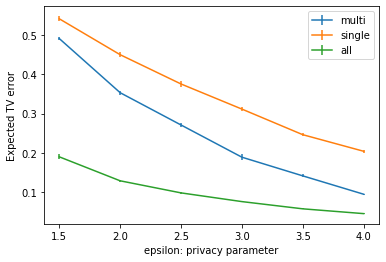

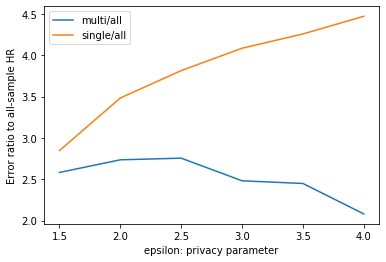

In [152]:
save_dir = './results/'
rep = 5
k = 1000
n = k*600
C_I = 0.6
prob = f.generate_uniform_distribution(k)
interactive = False
filename = f'k={k},n={n},C_I={C_I},distr=uniform,interact={interactive}.pkl'
eps_list = [1.5, 2, 2.5, 3, 3.5, 4]
m_list = [20]

save_path = os.path.join(save_dir, filename)
non_int_experiment = PlotExperiment(prob, k, n, C_I, rep, save_filename=save_path, interactive=interactive, verbose=True)
non_int_experiment.run_experiment(eps_list, m_list)
non_int_experiment.save_result(save_path)
config = non_int_experiment.load_result(save_path)
non_int_experiment.plot_eps(m=20)